# Recomendação de  Leads

O objetivo deste produto é fornecer um serviço automatizado que recomenda leads para um usuário dado sua atual lista de clientes (Portfólio).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import preprocessing_lib as prep
import recommendation_lib as rec
import time

from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

%matplotlib inline

plt.rcParams['xtick.labelsize']  = 12
plt.rcParams['ytick.labelsize']  = 12
plt.rcParams['axes.labelsize']   = 12
plt.rcParams['axes.titlesize']   = 12
plt.rcParams['legend.fontsize']  = 12

## Pré-processamento

A primeira etapa consiste em carregar o dataset contendo informações sobre as empresas do mercado a ser considerado. 

Utilizando os métodos desenvolvidos na biblioteca de pré-processamento, o mesmo foi filtrado de modo que apenas as colunas com menos de 30% de dados faltando foram consideradas. Dessas, apenas os parâmetros numéricos foram considerados e seus dados faltantes foram imputados com os valores de suas respectivas medianas.

In [2]:
market = prep.loading_data('../data/estaticos_market.csv')
market = prep.preprocessamento(market, fillna_param='mediana')
market.head()

,idade_empresa_anos,vl_total_veiculos_pesados_grupo,vl_total_veiculos_leves_grupo,nu_meses_rescencia,qt_socios,qt_socios_pf,qt_socios_pj,vl_faturamento_estimado_aux,vl_faturamento_estimado_grupo_aux,qt_filiais
0,14.457534,0.0,0.0,23.0,2.0,2.0,0.0,3132172.8,3132172.8,0
1,1.463014,0.0,0.0,9.0,1.0,1.0,0.0,210000.0,210000.0,0
2,7.093151,0.0,0.0,26.0,1.0,1.0,0.0,50000.0,50000.0,0
3,6.512329,0.0,0.0,26.0,1.0,1.0,0.0,210000.0,210000.0,0
4,3.200000,0.0,0.0,27.0,1.0,1.0,0.0,210000.0,210000.0,0


## Análise

Visualizando as distribuições dos parâmetros e a relação existente entre eles utilizando pair plots e matriz de correlação.

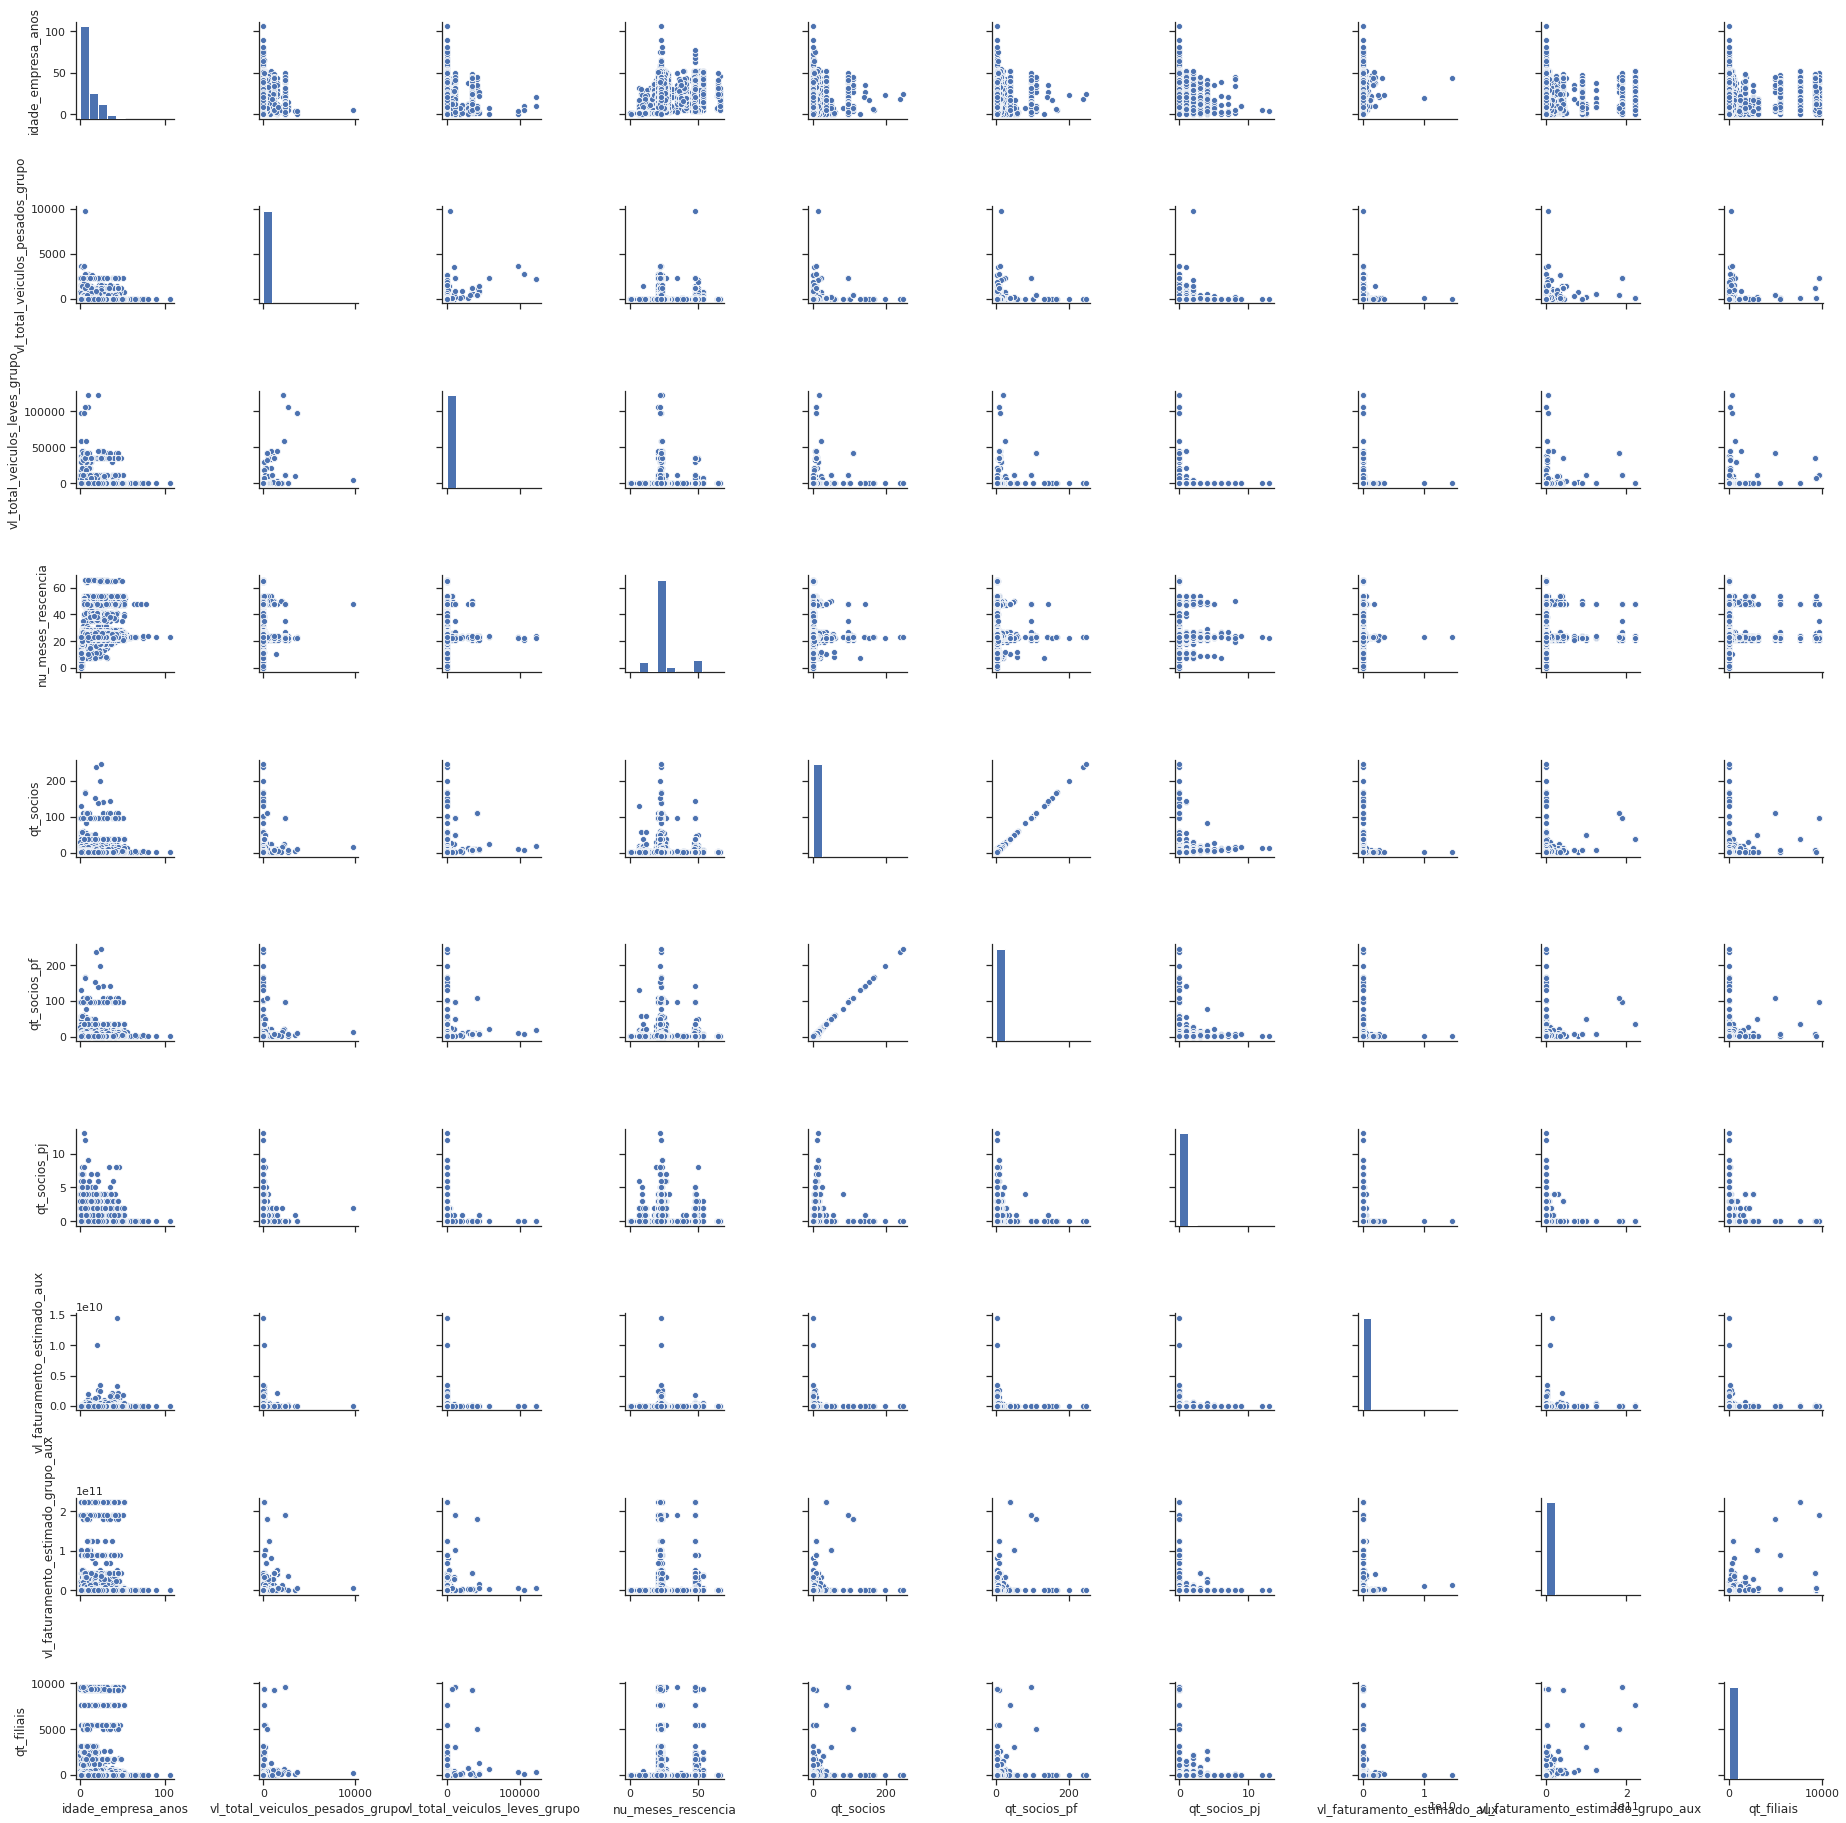

In [3]:
sns.set(style="ticks", color_codes=True)

sns.pairplot(market)

In [4]:
market.corr().style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'),axis=1)

,idade_empresa_anos,vl_total_veiculos_pesados_grupo,vl_total_veiculos_leves_grupo,nu_meses_rescencia,qt_socios,qt_socios_pf,qt_socios_pj,vl_faturamento_estimado_aux,vl_faturamento_estimado_grupo_aux,qt_filiais
idade_empresa_anos,1.0,0.043,0.053,0.22,0.045,0.045,0.0033,0.029,0.043,0.058
vl_total_veiculos_pesados_grupo,0.043,1.0,0.64,0.0081,0.69,0.69,0.026,0.014,0.63,0.68
vl_total_veiculos_leves_grupo,0.053,0.64,1.0,0.012,0.33,0.33,0.00043,0.0032,0.36,0.67
nu_meses_rescencia,0.22,0.0081,0.012,1.0,0.0067,0.0065,0.0045,0.00066,0.0085,0.023
qt_socios,0.045,0.69,0.33,0.0067,1.0,1.0,0.13,0.01,0.78,0.56
qt_socios_pf,0.045,0.69,0.33,0.0065,1.0,1.0,0.069,0.0093,0.79,0.56
qt_socios_pj,0.0033,0.026,0.00043,0.0045,0.13,0.069,1.0,0.017,0.0096,0.018
vl_faturamento_estimado_aux,0.029,0.014,0.0032,0.00066,0.01,0.0093,0.017,1.0,0.014,0.0048
vl_faturamento_estimado_grupo_aux,0.043,0.63,0.36,0.0085,0.78,0.79,0.0096,0.014,1.0,0.71
qt_filiais,0.058,0.68,0.67,0.023,0.56,0.56,0.018,0.0048,0.71,1.0


Observa-se que há diversas variáveis com alta correlação positiva. Inclusive os parâmetros 'qt_socios' e 'qt_socios_pf' são perfeitamente correlacionadas. Porém, nesse primeiro momento nenhuma dessas colunas delas será descartada.

Também nota-se que as distribuições possuem alta skewness e provavelmente isso se dá pelo grande número de zeros. Isso será avaliado abaixo onde suas médias, medianas, moda e skewness serão calculados.

In [5]:
pd.DataFrame({'mean': market.mean(),
              'median': market.median(),
              'moda': market.mode().T[0],
              'skewness': market.skew()}).sort_values(by='skewness',ascending=False)

,mean,median,moda,skewness
vl_faturamento_estimado_aux,7.668537e+05,210000.00000,210000.000000,339.307158
vl_total_veiculos_leves_grupo,4.849618e+01,0.00000,0.000000,34.560166
qt_socios_pf,1.358009e+00,1.00000,1.000000,31.809139
vl_total_veiculos_pesados_grupo,3.576829e+00,0.00000,0.000000,31.327581
qt_socios,1.372764e+00,1.00000,1.000000,31.306024
vl_faturamento_estimado_grupo_aux,3.166936e+08,210000.00000,210000.000000,27.635134
qt_filiais,2.873704e+01,0.00000,0.000000,18.666386
qt_socios_pj,1.475455e-02,0.00000,0.000000,17.085841
nu_meses_rescencia,2.481066e+01,23.00000,23.000000,1.383117
idade_empresa_anos,9.948677e+00,6.70411,0.205479,1.376723


Com o objetivo de diminuir a skewness de todos os parâmetros e tentar aproximar suas médias, medianas e moda, uma transformação logarítmica será aplicada. Nela, será calculada o valor de log(x+1) para cada variável de modo que, aquelas que possuem valor igual a zero não tenha resultado infinito.

Abaixo observa-se como ficaram as medidas e as distribuições após a transformação.

In [6]:
pd.DataFrame({'mean': np.log(market+1).mean(),
              'median': np.log(market+1).median(),
              'moda': np.log(market+1).mode().T[0],
              'skewness': np.log(market+1).skew()}).sort_values(by='skewness',ascending=False)

,mean,median,moda,skewness
qt_socios_pj,0.008632,0.000000,0.000000,11.428014
vl_total_veiculos_pesados_grupo,0.082517,0.000000,0.000000,8.975873
vl_total_veiculos_leves_grupo,0.142200,0.000000,0.000000,8.464125
qt_filiais,0.180405,0.000000,0.000000,7.024373
qt_socios_pf,0.791413,0.693147,0.693147,5.274125
qt_socios,0.795057,0.693147,0.693147,5.087904
vl_faturamento_estimado_grupo_aux,12.380442,12.254868,12.254868,3.593809
idade_empresa_anos,2.000528,2.041754,0.186877,-0.136214
nu_meses_rescencia,3.190094,3.178054,3.178054,-0.638609
vl_faturamento_estimado_aux,12.134097,12.254868,12.254868,-2.075866


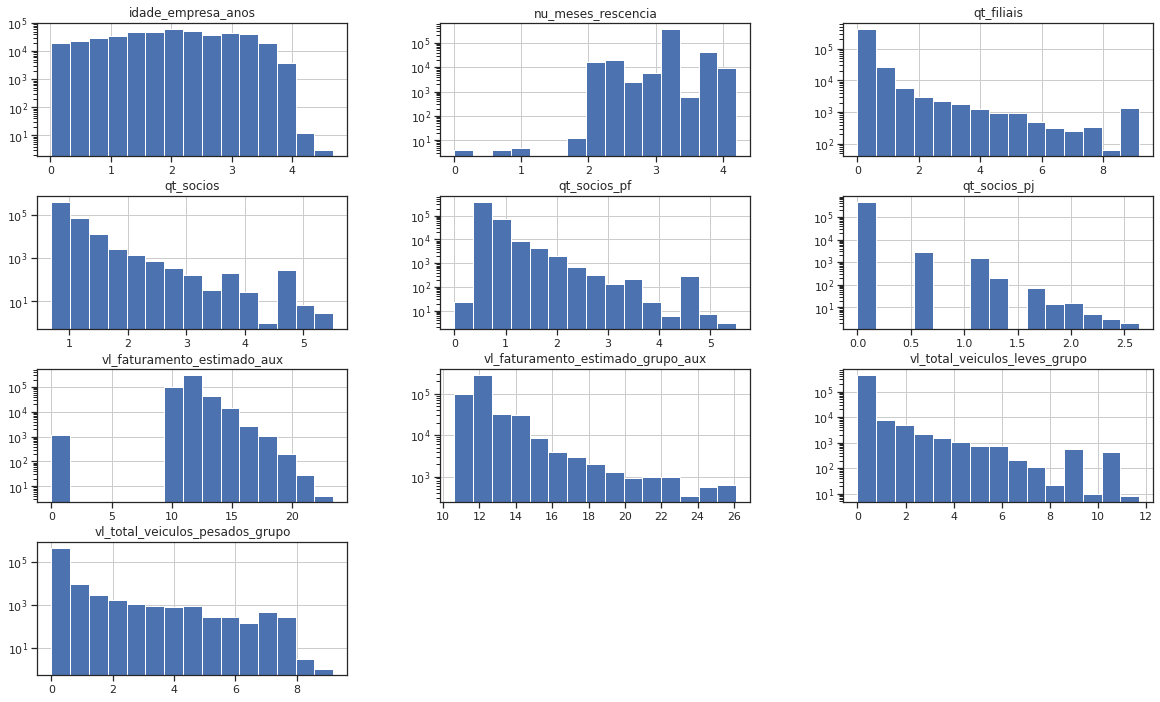

In [7]:
np.log(market+1).hist(bins=15,figsize=(20,12),log=True);

## Modelagem do Algoritmo de Clusterização

O algortimo KMeans foi adotado para realizar a clusterização do dataset de mercado e, para selecionar o número de clusters, o "elbow method" foi utilizado.

Antes de iniciar o treinamento, os dados foram normalizados utilizando o método dos mínimos e máximos.

In [8]:
market_transform = MinMaxScaler().fit_transform(np.log(market+1))

In [9]:
elb  = []
kmax = 100

for k in tqdm(range(5, kmax+1, 5)):
    kmeans = KMeans(n_clusters = k, random_state=42).fit(market_transform)
    elb.append(kmeans.inertia_)

100%|██████████| 20/20 [30:40<00:00, 92.01s/it] 


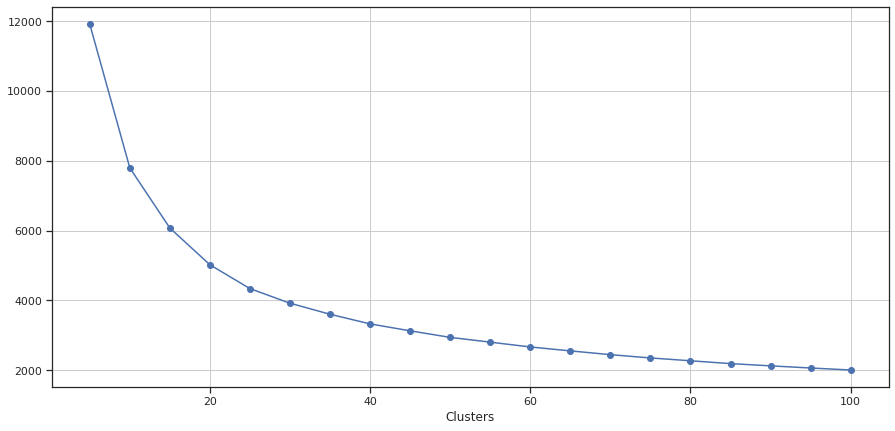

In [10]:
k = list(range(5,101,5))

plt.figure(figsize=(15,7))
plt.plot(k,elb,'-o');
plt.grid()
plt.xlabel('Clusters')
plt.show()

In [11]:
#print("Silhouette Score: ", silhouette_score(market_transform, labels, metric = 'cosine'))

Após análise dos resultados obtidos com diferentes quantidades de clusters, foi determinado que no sistema de recomendação a ser desenvolvido serão utilizados 25 clusters como padrão.

## Sistema de Recomendação

A seguir o sistema de recomendação será apresentado, assim como todos os métodos desenvolvidos em sua biblioteca.

Primeiramente, o dataset transformado e normalizado é utilizado para treinar o algoritmo de clusterização adotado e um dataset com os ids de cada lead e seus respectivos cluster labels será obtido.

In [12]:
market_transform = MinMaxScaler().fit_transform(np.log(market+1))

kmeans = rec.kMeans_training(market_transform)

market_labels = rec.market_clusters(kmeans)
market_labels.head()

,id,label
0,a6984c3ae395090e3bee8ad63c3758b110de096d5d8195...,17
1,6178f41ade1365e44bc2c46654c2c8c0eaae27dcb476c4...,5
2,4a7e5069a397f12fdd7fd57111d6dc5d3ba558958efc02...,15
3,3348900fe63216a439d2e5238c79ddd46ede454df7b9d8...,12
4,1f9bcabc9d3173c1fe769899e4fac14b053037b953a1e4...,11


O portfólio 3 será adotado como exemplo e, com base no dataset market_labels, as labels para este portfólio serão obtidos. 

In [13]:
portfolio3 = prep.loading_data('../data/estaticos_portfolio3.csv')
portfolio3 = rec.portfolio_clusters(market_labels, portfolio3)
portfolio3.head()

,id,label
0,bb61c09449a1c1f8b78955d8b7a7f73599e78358993fe2...,23
1,16843c9ffb920170477118933798510d8d5f00f5c56c12...,23
2,1b8d092daff12bed8b3c2ab93bf5df2921865a68aca185...,23
3,3aafa3a1f12f483740a52956af100223333d0e3c79bf2c...,23
4,c60431fbca90067f105570e1e8a684bcd7048205bbf6c4...,17


Para a recomendação de novos leads, o algoritmo leva em consideração o cluster que possui maior número de eventos no portfólio em questão. Para o portfólio 3, serão recomendados os leads que se encontram no cluster 23 e que não estão na lista de clientes apresentada.

In [14]:
portfolio3['label'].value_counts()

23    196
17     23
21     19
3      12
24      7
6       4
8       2
14      1
5       1
Name: label, dtype: int64

In [15]:
recommended_leads = rec.recommend_leads(portfolio3, market_labels)
recommended_leads.head()

,id
85,f2121195844a29cebd481b010539992da720b58616e43b...
123,6e292487550f4b68a5a710b1512039761b07cdb9d11257...
419,a1435b4a6ff818f99eb7da8da497686701a269df822132...
645,59d43a34290fd77e9b35e6eb5374ca7bd3ef67a2e1c507...
734,36e0997efc1b58e19210ea8c9577ac628aea94c193bbf6...
